# 0: Curifactory Basic Components

This notebook introduces the four basic components of curifactory and shows how to use them from a live context. (A live context is either a notebook, REPL, or non-experiment script)

The components are:
* the artifact manager
* arguments
* records
* stages

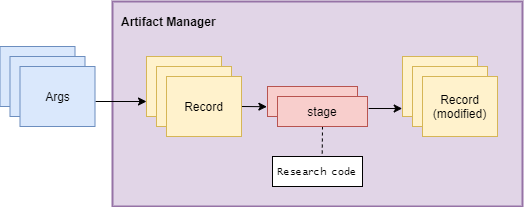

In [1]:
# note that curifactory assumes that the active directory is the project root
%cd ..

C:\Users\81n\lab\curifactory\examples\notebook-based


## Artifact Manager

First up is the **artifact manager**. `ArtifactManager` is a class representing a session that tracks metadata and generated objects from experiment code.

When an artifact manager is instantiated, it creates a new "experiment run", which will have an associated log file and can generate a run-specific report.

In [2]:
from curifactory import ArtifactManager

manager = ArtifactManager("notebook_example_0") # we pass in a name to associate with this run.

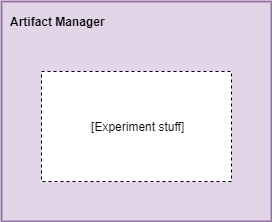
_The artifact manager contains and keeps track of the overall session for the experiment stuff._

## Arguments

The next component is **arguments**. Argument classes are a way to define how research code can be parameterized, e.g. how many layers to include in a neural network. By defining and initializing these directly in python, we have the ability to dynamically create experiment parameter configurations, compose them, etc.

Curifactory comes with an `ExperimentArgs` superclass that all args classes should inherit from. `ExperimentArgs` a `name` parameter, allowing you to provide a label for an args set.

For best ergonomics, we recommend defining an args class with the python `@dataclass` decorator. This makes it easy to define defaults and quickly view your argument definitions simply as a collection of parameters.

Arg sets can then be initialized, passed around, and used within your research code, making it easy to organize and keep track of hyperparameters.

In [3]:
from dataclasses import dataclass
from curifactory import ExperimentArgs

@dataclass
class MyArgs(ExperimentArgs):
    some_scalar_multiplier: float = 1.0
        
# define a couple argument sets
default_args = MyArgs(name="default")
doubled_args = MyArgs(name="doubled", some_scalar_multiplier=2.0)

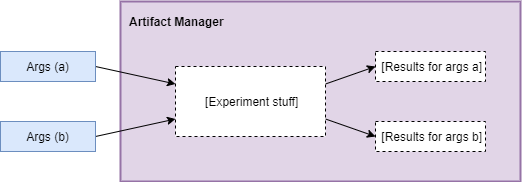
_Creating and passing different argument sets through the experiment stuff will give us different sets of results in the manager we can compare._

## Records

A **record** is how curifactory keeps track of state in an experiment run. "State" includes the data, objects, and results associated with a set of arguments, e.g. a trained model that came from using a particular `MyArgs` instance. The `Record` class is initialized with the current manager as well as the argument set to associate with. Records have a `state` dictionary, which holds intermediate data and objects as research code is evaluated.

In [4]:
from curifactory import Record

r0 = Record(manager, default_args)
r1 = Record(manager, doubled_args)

print(r0.state, r0.args)
print(r1.state, r1.args)

{} MyArgs(name='default', hash=None, overwrite=False, some_scalar_multiplier=1.0)
{} MyArgs(name='doubled', hash=None, overwrite=False, some_scalar_multiplier=2.0)


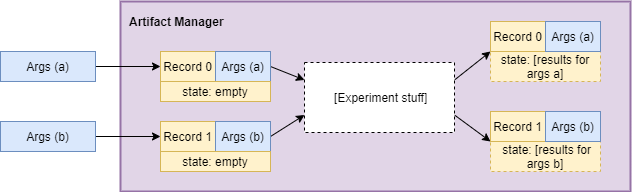
_The state for each record is what’s actually storing the results from the experiment stuff for each given arg set._

## Stages

A **stage** represents a small, well-defined abstraction around portions of research code which process some set of inputs and create a set of outputs. A stage acts on a given  record by taking the requested inputs from that record's state, evaluates some code, and returning values that are then stored in the record's state. This is implemented with a `@stage` decorator which takes an array of string input names and an array of string output names. Functions with the `@stage` decorator must accept a record as the first argument. 

Inside the stage, the record parameter can be used to obtain the arguments necessary to parameterize the computation, via the `record.args` attribute.

In the example below, we've defined a very simple stage that will store a number in the record's state under the "initial_value" key.

Running a stage works by calling the function and passing it the record. The record itself is changed in-place, but it is also directly returned from the stage call. This allows functionally chaining stages, as will be shown later.

In [6]:
from curifactory import stage

@stage(inputs=None, outputs=["initial_value"])
def get_initial_value(record):
    my_value = 5
    return my_value * record.args.some_scalar_multiplier

r0 = get_initial_value(r0)
r1 = get_initial_value(r1)

2022-02-03 08:48:01,282 [INFO] - [default] -----
2022-02-03 08:48:01,283 [INFO] - [default] Stage get_initial_value
2022-02-03 08:48:01,284 [INFO] - [default] Stage get_initial_value executing...
2022-02-03 08:48:01,284 [INFO] - [default] Stage get_initial_value complete
2022-02-03 08:48:01,284 [INFO] - [doubled] -----
2022-02-03 08:48:01,284 [INFO] - [doubled] Stage get_initial_value
2022-02-03 08:48:01,284 [INFO] - [doubled] Stage get_initial_value executing...
2022-02-03 08:48:01,284 [INFO] - [doubled] Stage get_initial_value complete


After running both records through our stage, printing the states shows the returned `initial_value` data.

In [7]:
print(r0.state, r1.state)

{'initial_value': 5.0} {'initial_value': 10.0}


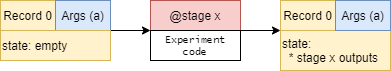
_Stages are the “experiment stuff”. A stage uses and modifies the state of a passed record. This is where the experiment code actually runs, taking any necessary inputs from the passed record state and storing any returned outputs back into it._

Specifying inputs on the stage decorator tells curifactory to search for those keys in the state of the passed record. Those values are then injected into the record call as kwargs. Note that the parameter names in the function definition must match the string values of the inputs array.

`"initial_value"` was added to the state from the `get_initial_value` stage, so we implement a stage below that expects that piece of data and computes a new value based on it.

In [8]:
@stage(inputs=["initial_value"], outputs=["final_value"])
def multiply_again(record, initial_value):
    return initial_value * record.args.some_scalar_multiplier

r1 = multiply_again(r1)
print(r1.state)

2022-02-03 08:48:36,946 [INFO] - [doubled] -----
2022-02-03 08:48:36,946 [INFO] - [doubled] Stage multiply_again
2022-02-03 08:48:36,946 [INFO] - [doubled] Stage multiply_again executing...
2022-02-03 08:48:36,946 [INFO] - [doubled] Stage multiply_again complete
{'initial_value': 10.0, 'final_value': 20.0}


As mentioned before, since a stage accepts and returns a record, stages can be functionally chained together:

In [9]:
r2 = Record(manager, MyArgs(name="uber-double", some_scalar_multiplier=4.0))

r2 = multiply_again(get_initial_value(r2))
print(r2.state, r2.args)

2022-02-03 08:48:52,927 [INFO] - [uber-double] -----
2022-02-03 08:48:52,927 [INFO] - [uber-double] Stage get_initial_value
2022-02-03 08:48:52,927 [INFO] - [uber-double] Stage get_initial_value executing...
2022-02-03 08:48:52,927 [INFO] - [uber-double] Stage get_initial_value complete
2022-02-03 08:48:52,927 [INFO] - [uber-double] -----
2022-02-03 08:48:52,927 [INFO] - [uber-double] Stage multiply_again
2022-02-03 08:48:52,927 [INFO] - [uber-double] Stage multiply_again executing...
2022-02-03 08:48:52,927 [INFO] - [uber-double] Stage multiply_again complete
{'initial_value': 20.0, 'final_value': 80.0} MyArgs(name='uber-double', hash=None, overwrite=False, some_scalar_multiplier=4.0)


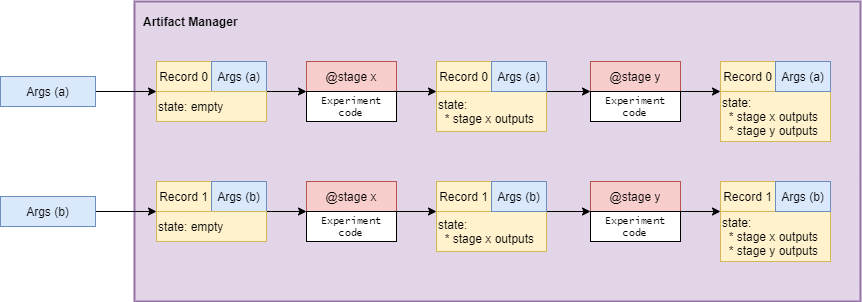
_Records can be “pipelined” through sequences of stages to create a full experiment composed of larger abstract steps._

Records and stages represent linear tracks of compute steps, but in many cases it's important to compare across multiple pieces of an experiment run (e.g. comparing the scores of an SVM with the scores of a logistic regression algorithm.) `@aggregate` decorated functions are a special kind of stage that have no explicit inputs, but instead take a collection of records to compute over. Aggregate stages still produce outputs and both take and return a single record associated with it, meaning additional regular stages can be chained after an aggregate stage.

`@aggregate` decorated stages must take the single record as the first parameter (like a normal stage,) and the collection of records to compute over as the second.

In the example below, we iterate through the records to create a dictionary of all associated `final_value` entries from each record's state, and then determine the maximum.

In [10]:
from curifactory import aggregate

@aggregate(outputs=["all_final_values", "maximum_value"])
def find_maximum_final_value(record, records):
    all_vals = {}
    for r in records:
        if "final_value" in r.state:
            all_vals[r.args.name] = r.state["final_value"]
        
    maximum = max(all_vals.values())
    return all_vals, maximum

Sometimes an aggregate doesn't really need it's own set of arguments, e.g. if it's simply comparing results from other records. In these cases, records can be initialized with `None` passed as the argset. In the cell below, we manually pass our previous records into the stage, but note that if we pass `None` for records, it will take all existing records in the manager.

In [11]:
final_record = Record(manager, None)
final_record = find_maximum_final_value(final_record, [r0, r1, r2])
print(final_record.state)

2022-02-03 08:50:10,155 [INFO] - -----
2022-02-03 08:50:10,155 [INFO] - Stage (aggregate) find_maximum_final_value
2022-02-03 08:50:10,155 [INFO] - Stage (aggregate) find_maximum_final_value executing...
2022-02-03 08:50:10,155 [INFO] - Stage (aggregate) find_maximum_final_value complete
{'all_final_values': {'doubled': 20.0, 'uber-double': 80.0}, 'maximum_value': 80.0}


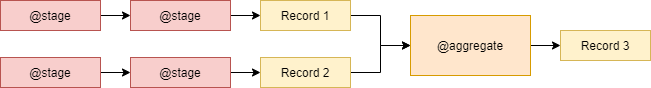

To recap, the artifact manager keeps track of the overall session for a
run, the “experiment run container”. Sets of arguments are created with
different hyperparameters to test a hypothesis or vary the experiment.
Records track state changes and intermediate data associated with some
set of arguments throughout the experiment. Stages are what modify record state,
they apply research code
to the passed records based on their associated arguments, and the
results for each stage are stored back into the record’s now modified
state.


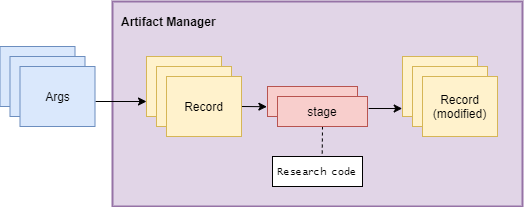